In [20]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import time
import torch.utils.data
from tqdm import tqdm
from generate import write_file, generate

In [21]:
from train_models import LstmDiscriminator, FeaturedLstmDiscriminator, LstmBaseline
from scores import EB, UPC, QN

In [22]:
def g_loss(p_fake,sound,in_probs,p_baseline, eps = 1e-8):
        
    probs = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
            +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])
        
    return -((probs+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-p_baseline)).mean(), probs

def g_loss_monte_carlo(p_fakes,sounds,in_probs,p_baseline, eps = 1e-8):
    
    loss = 0
    for sound, p_fake in zip(sounds, p_fakes):
        probs = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
                +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])
        loss += -((probs+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-p_baseline)).mean()
        
    return loss/5, probs

def d_loss(p_fake, p_true,eps = 1e-8):
    return -(1-p_fake+eps).log().mean()-(p_true+eps).log().mean()
    
def bl_loss(bl_pred,real_reward):
    return (bl_pred-real_reward).pow(2).mean()


In [23]:
import torch.utils.data

def sample_sound(data_gen):
    size = data_gen.size()
    rand = torch.rand(*size).cuda()
    sample = (rand<data_gen).type(torch.FloatTensor).cuda()
    sample[:,:,:,2] = sample[:,:,:,0]
    return sample


In [24]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 128

from dataset import load_all
from constants import *

In [25]:
styles= [['data/Bach1']]
X_tr, y_tr = load_all(styles, BATCH_SIZE, SEQ_LEN)
print(X_tr.shape)

X_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.FloatTensor(X_tr),
            torch.FloatTensor(y_tr))),\
            batch_size=8,shuffle=True)

(81, 128, 48, 3)


In [26]:
def train_discriminator(num_epochs = 3,d_lr = 0.001, verbose = True):

    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr,) #, weight_decay = 1, betas=(0.5, 0.999))  
    
    history = {'d_losses':[], 'prop_machine':[],
               'prob_human':[], 'prob_noise':[], 'color':[]}

    generator.eval()
        
    for epoch in range(num_epochs):        
        start_time = time.time()
        for i, [x_batch,ch_batch] in tqdm(enumerate(X_loader)):
            try:
                x_batch = x_batch.cuda()
                ch_batch = ch_batch.cuda()
                
                x_batch[:,:,:,2] = x_batch[:,:,:,0] #1 #x_batch[:,:,:,0]
                ch_batch[:,:,:,2] = ch_batch[:,:,:,0] # 1 #ch_batch[:,:,:,0]

                # Optimize D  
                # rand_like ones_like            
                noise_example = sample_sound(torch.rand_like(x_batch).cuda()), x_batch
                true_example = ch_batch , x_batch
                p_true_example = discriminator(*true_example)
                p_noise_example = discriminator(*noise_example)
                loss = d_loss(p_noise_example, p_true_example)
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()            

                # machine generation
                data_gen, sound = generator(x_batch,ch_batch)
#                 sound = sample_sound(data_gen).data          
                false_example = sound, x_batch
                true_example = ch_batch, x_batch
                p_true_example = discriminator(*true_example)
                p_false_example = discriminator(*false_example)
                loss = d_loss(p_false_example, p_true_example)
                
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                
                # history
                history['d_losses'].append(loss.data.cpu().numpy())
                history['prop_machine'].append(p_false_example.mean().data.cpu().numpy())
                history['prob_human'].append(p_true_example.mean().data.cpu().numpy())
                history['prob_noise'].append(p_noise_example.mean())
                
            except KeyboardInterrupt:
                return history

    #       # Visualize
        if verbose:
            display.clear_output(wait=True)
            plt.figure(figsize=(16, 6))

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time)) 
            print('mean probability of human generation: {}'.format(history['prob_human'][-1]))
#             print('mean probability of noise generation: {}'.format(prob_noise[-1]))
            print('mean probability of machine generation: {}'.format(history['prop_machine'][-1]))

            plt.title("losses")
            plt.subplot(121)
            plt.plot(history['prob_human'],label = "probability of human generation")
            plt.plot(history['prop_machine'],label = "probability of machine generation")
            plt.legend()
            plt.subplot(122)
            plt.plot(history['d_losses'],label = "Discriminator loss")
            plt.legend()
            plt.show()
                
            
    return history

In [27]:
# h= train_discriminator( num_epochs = 1, d_lr=1e-3)

In [28]:
def train_generator(num_epochs = 3,g_lr = 0.001, verbose=True, monte_carlo=True, teacher_forcing = 2):
    
    g_optimizer = torch.optim.Adam(generator.parameters(),  lr=g_lr, betas=(0.5, 0.999))#, betas=(0.5, 0.999))
    
    history = {'g_losses':[],'prop_machine':[],
               'prob_human':[],'prob_confidence':[],'prob_noise':[],
                  'EB_true':[], 'UPC_true':[], 'QN_true':[], 'EB_false':[], 'UPC_false':[], 'QN_false':[]}
    
    generator.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, [x_batch,ch_batch] in tqdm(enumerate(X_loader)):
            
            try:
                
                x_batch = x_batch.cuda()
                ch_batch = ch_batch.cuda()
                
                x_batch[:,:,:,2] = x_batch[:,:,:,0] #1 #x_batch[:,:,:,0]
                ch_batch[:,:,:,2] = ch_batch[:,:,:,0] #1 #ch_batch[:,:,:,0]

                # baseline
                p_baseline = baseline(x_batch,ch_batch)

                #generator
                # monte carlo false example sampling
                data_gen, sound = generator(x_batch,ch_batch)
                if monte_carlo:
                    p_false_examples = []
                    sounds = []

                    for _ in range(5):                  
    #                     sound = sample_sound(data_gen).data                 
                        false_example = sound.detach(), x_batch.detach()
                        p_false_example = discriminator(*false_example)
                        p_false_examples.append(p_false_example)
                        sounds.append(sound)
                else:
    #                 sound = sample_sound(data_gen).data                 
                    false_example = sound.detach(), x_batch.detach()
                    p_false_example = discriminator(*false_example)


                true_example = ch_batch.detach(), x_batch.detach()
                p_true_example = discriminator(*true_example)

                # Optimize G  
                handle = np.random.randint(0,teacher_forcing-1)
#                 handle = 0
                if handle != 0:
                    if monte_carlo:
                        loss, confidence = g_loss_monte_carlo(p_false_examples,
                                  sounds,data_gen,p_baseline)

                    else:
                        loss, confidence = g_loss(p_false_example,
                                  sound,data_gen,p_baseline)

                else:
                    loss, confidence = g_loss(1,
                                  ch_batch,data_gen,p_baseline)


#                 loss+=compute_loss(data_gen, ch_batch)    
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
                
            except KeyboardInterrupt:
                return history
        
        # history
        history['g_losses'].append(loss.data.cpu().numpy())
        history['prob_human'].append(p_true_example.mean().data.cpu().numpy())
        history['prop_machine'].append(p_false_example.mean().data.cpu().numpy())
        history['prob_confidence'].append(confidence.mean().data.cpu().numpy())
        history['EB_true'].append(EB(ch_batch).mean().data.cpu().numpy())
        history['UPC_true'].append(UPC(ch_batch).mean().data.cpu().numpy())
        history['QN_true'].append(QN(ch_batch).mean().data.cpu().numpy())
        history['EB_false'].append(EB(sound).mean().data.cpu().numpy())
        history['UPC_false'].append(UPC(sound).mean().data.cpu().numpy())
        history['QN_false'].append(QN(sound).mean().data.cpu().numpy())

        # Visualize
        if verbose:
            display.clear_output(wait=True)
            plt.figure(figsize=(16, 6))

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time)) 
            print('mean probability of human generation: {}'.format(history['prob_human'][-1]))
            print('mean probability of machine generation: {}'.format(history['prop_machine'][-1]))
    #         print('mean probability of noise generation: {}'.format(prob_noise[-1]))
            print('mean probability of machine generation confidence: {}'.format(history['prob_confidence'][-1]))


            plt.title("losses")
            plt.subplot(231)
            plt.plot(history['prob_human'], label = "Human probability")
            plt.plot(history['prop_machine'], label = "Machine probability")
            plt.legend()
            plt.subplot(232)
            plt.plot(history['g_losses'], label = "Generator loss")
            plt.legend()
            plt.subplot(233)
            plt.plot(history['prob_confidence'],label = "Machine confidence")
            plt.legend()
            plt.subplot(234)
            plt.plot(history['EB_true'],label = "EB_true")
            plt.plot(history['EB_false'],label = "EB_false")
            plt.legend()
            plt.subplot(235)
            plt.plot(history['UPC_true'],label = "UPC_true")
            plt.plot(history['UPC_false'],label = "UPC_false")
            plt.legend()
            plt.subplot(236)
            plt.plot(history['QN_true'],label = "QN_true")
            plt.plot(history['QN_false'],label = "QN_false")
            plt.legend()
            plt.show()
  
    return history

In [29]:
# train_generator(num_epochs = 100, g_lr=1e-3, verbose = True)

In [30]:
def train_baseline(num_epochs = 3, b_lr = 0.001, verbose=True):
    
    bl_optimizer = torch.optim.Adam(baseline.parameters(),  lr=b_lr)
    
    bl_losses = []
    prob_baseline = []     
    generator.eval()
    
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, [x_batch,ch_batch] in tqdm(enumerate(X_loader)):
            
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()
            
            # Optimize BL
            data_gen, sound = generator(x_batch,ch_batch)
#             sound = sample_sound(data_gen).data
            false_example = sound.detach(), x_batch.detach()
            p_baseline = baseline(x_batch,ch_batch)
            p_false_example = discriminator(*false_example)
            loss = bl_loss(p_baseline, p_false_example)
            
            bl_optimizer.zero_grad()
            loss.backward()
            bl_optimizer.step()
            
            # history
            bl_losses.append(loss.data.cpu().numpy())
            prob_baseline.append(p_baseline.mean().data.cpu().numpy())

            
    return np.array(prob_baseline),np.array(bl_losses)

In [31]:
# discriminator = FeaturedLstmDiscriminator(hidden_size=1000,last_dim=78*2).cuda()
# generator = Generator().cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical_attention')))

In [32]:
# prob_human, prop_machine, d_losses = train_discriminator( num_epochs = 40, d_lr=1e-3)

In [33]:
# torch.save(discriminator.state_dict(), os.path.join(OUT_DIR, 'discriminator'))

In [34]:
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
# baseline = LSTM_baseline(hidden_size=10).cuda()
# generator,prob_human, prop_machine, prob_confidence, g_losses= train_generator(generator, discriminator, baseline, X_loader, num_epochs = 30, g_lr=1e-3)

In [35]:
def plot_history(history):
    
    plt.figure(figsize=(16, 6))
    plt.title("losses")
    plt.subplot(331)
    plt.plot(history['g_losses'],label = "Generator loss")
    plt.legend()
    plt.subplot(332)
    plt.plot(history['d_losses'],label = "Discriminator loss")
    plt.legend(loc=2)
    plt.subplot(333)
    plt.plot(history['bl_losses'],label = "Baseline loss")
    plt.legend()
    plt.subplot(334)
    g_machine = np.asarray(history['prop_machine'].copy())
    d_machine = np.asarray(history['prop_machine'].copy())
    g_machine[np.asarray(history['color']) == 1] = np.nan
    d_machine[np.asarray(history['color']) == 0] = np.nan
    plt.plot(g_machine, 'o', label = "Machine P - generator", color = 'blue' )
    plt.plot(d_machine, 'o', label = "Machine P - discriminator", color = 'orange' )
    plt.plot(history['prob_human'], 'o', label = "Human P", color = 'green')
    plt.legend(loc=2)
    plt.subplot(335)
    plt.plot(history['prob_confidence'],label = "Machine confidence")
    plt.legend()
    plt.subplot(336)
    plt.plot(history['prop_baseline'],label = "Baseline probabilyty")
    plt.legend()
    plt.subplot(337)
    plt.plot(history['EB_true'],label = "EB_true")
    plt.plot(history['EB_false'],label = "EB_false")
    plt.legend()
    plt.subplot(338)
    plt.plot(history['UPC_true'],label = "UPC_true")
    plt.plot(history['UPC_false'],label = "UPC_false")
    plt.legend()
    plt.subplot(339)
    plt.plot(history['QN_true'],label = "QN_true")
    plt.plot(history['QN_false'],label = "QN_false")
    plt.legend()
    plt.show()
    
    
def train_GAN(g_lr = 0.001, d_lr = 0.001, bl_lr = 0.001, history = None):
    
    if not history:     
        history = {'d_losses':[],'g_losses':[],'bl_losses':[],'prop_machine':[],
               'prob_human':[],'prob_confidence':[1,],'prop_baseline':[], 'prob_noise':[], 'color':[],
                  'EB_true':[], 'UPC_true':[], 'QN_true':[], 'EB_false':[], 'UPC_false':[], 'QN_false':[]}
    
    epoch = 0
    n_epochs = 100
    it_generator = 0
    criterion = True

    while epoch<n_epochs:
        start_time = time.time()
        epoch+=1
        
        try:     
            p_baseline, bl_l = train_baseline(num_epochs = 1,b_lr = 0.001, verbose=False)
            history['prop_baseline'].extend(p_baseline)
            history['bl_losses'].extend(bl_l) 
            
            if criterion:
                it_generator = 0
                generator.eval()
                h= train_discriminator(num_epochs = 1, d_lr=d_lr, verbose = False)
                
                for k in h.keys():
                    history[k].extend(h[k])
                history['color'].extend(np.ones(len(h['prob_human'])))
                
            else: 
                it_generator+=1
                generator.train()
                h = train_generator(num_epochs = 3, g_lr=g_lr, verbose = False)
                
                for k in h.keys():
                    history[k].extend(h[k])
                history['color'].extend(np.zeros(len(h['prob_human'])))
                
            p_human = np.array(history['prob_human'][:-5])
            p_machine =  np.array(history['prop_machine'][:-5])
            diff = np.maximum(p_human-p_machine,0).mean()
            criterion = (diff<0.3) or (p_human.mean()<0.9 and diff<0.3)
                
        except KeyboardInterrupt:
            return history  
        
        # Visualize
        display.clear_output(wait=True)
        # Then we print the results for this epoch:
        if history['color'][-1]==0:
            tr = 'generator trainig'
        else: tr = 'discriminator trainig'
        print("Epoch {} of {} took {:.3f}s, format {}".format(
            epoch, n_epochs, time.time() - start_time, tr))
        print('mean probability of machine generation: {}'.format(history['prop_machine'][-1]))
        print('mean probability of human generation: {}'.format(history['prob_human'][-1]))
    #         print('mean probability of noise generation: {}'.format(prob_noise[-1]))
        print('mean probability of machine generation confidence: {}'.format(history['prob_confidence'][-1]))

        plot_history(history)
            
    return history

In [36]:
# discriminator = LSTM_discriminator(hidden_size=500, last_dim=6).cuda()
discriminator = FeaturedLstmDiscriminator(hidden_size=1000,last_dim=78*2).cuda()
generator = Generator().cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
baseline = LstmBaseline(hidden_size=40).cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical_attention')))
generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_track_featured')))
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'generator_rl2'))) 
# discriminator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'discriminator')))
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'generator_rl')))

In [37]:
# discriminator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'discriminator')))
generator.note_ax.to_train=True
generator.note_ax.apply_T=False
generator.train()

Generator(
  (time_ax): time_axis(
    (attention_layer): MultiHeadAttention(
      (attention): ScaledDotProductAttention(
        (dropout): Dropout(p=0.1)
      )
      (proj): Linear(in_features=234, out_features=78, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (FF): PositionwiseFeedForward(
      (w_1): Linear(in_features=78, out_features=312, bias=True)
      (w_2): Linear(in_features=312, out_features=78, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (time_lstm): LSTM(78, 256, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2)
    (generate_features): feature_generation(
      (padding): ZeroPad2d(padding=(11, 12, 0, 0), value=0)
      (conv): Conv1d(3, 64, kernel_size=(24,), stride=(1,))
    )
  )
  (note_ax): note_axis(
    (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2)
    (logits): Linear(in_features=158, out_features=3, bias=True)
  )
  (overall_information): track_feature(
    (o

Epoch 14 of 2000 took 4.584s
mean probability of human generation: 0.6767334938049316
mean probability of machine generation: 0.6767457127571106


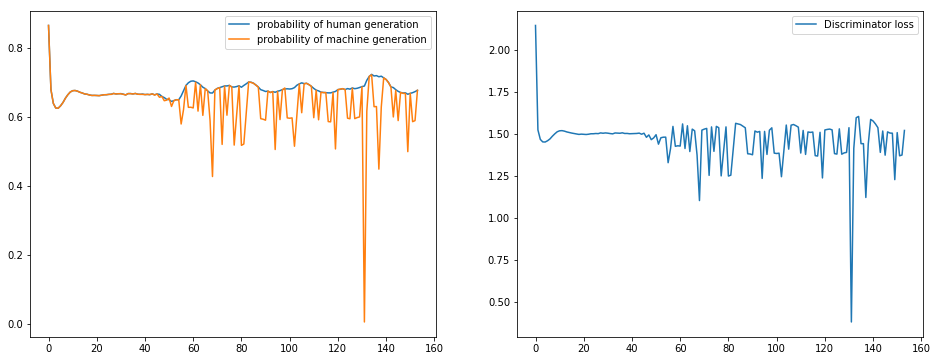

5it [00:02,  2.26it/s]

In [ ]:
h= train_discriminator( num_epochs = 2000, d_lr=1e-3)

In [22]:
p_baseline, bl_l = train_baseline(num_epochs = 2,b_lr = 0.001, verbose=False)

11it [00:00, 13.30it/s]
11it [00:00, 12.74it/s]


In [51]:
# generator = Generator().cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical_attention')))
generator.train()
h  = train_generator(num_epochs = 100, g_lr=1e-3, verbose = True, monte_carlo = True, teacher_forcing=2)

84it [00:16,  5.21it/s]

Epoch 3 of 100 took 253.286s, format generator trainig
mean probability of machine generation: 1.9777680790866725e-05
mean probability of human generation: 0.9999803900718689
mean probability of machine generation confidence: 0.9969903826713562


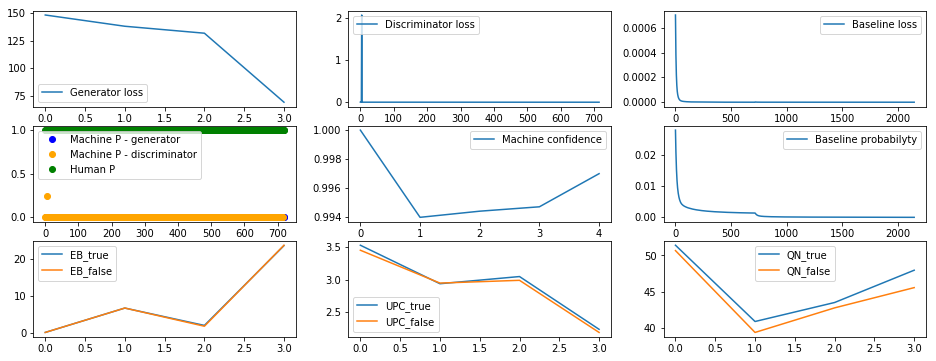


0it [00:00, ?it/s]
2it [00:00, 13.61it/s]
4it [00:00, 13.56it/s]
6it [00:00, 13.58it/s]
8it [00:00, 13.39it/s]
10it [00:00, 13.31it/s]
12it [00:00, 13.30it/s]
14it [00:01, 13.28it/s]
16it [00:01, 13.27it/s]
18it [00:01, 13.26it/s]
20it [00:01, 13.30it/s]
22it [00:01, 13.32it/s]
24it [00:01, 13.36it/s]
26it [00:01, 13.35it/s]
28it [00:02, 13.34it/s]
30it [00:02, 13.33it/s]
32it [00:02, 13.34it/s]
34it [00:02, 13.33it/s]
36it [00:02, 13.28it/s]
38it [00:02, 13.22it/s]
40it [00:03, 13.19it/s]
42it [00:03, 13.18it/s]
44it [00:03, 13.14it/s]
46it [00:03, 13.12it/s]
48it [00:03, 13.11it/s]
50it [00:03, 13.08it/s]
52it [00:03, 13.05it/s]
54it [00:04, 13.03it/s]
56it [00:04, 13.01it/s]
58it [00:04, 13.01it/s]
60it [00:04, 13.00it/s]
62it [00:04, 12.99it/s]
Exception in thread Thread-169:
Traceback (most recent call last):
  File "/opt/miniconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/miniconda/lib/python3.6/site-packages/tqdm/_monitor.py", line 6

In [55]:
history = None
generator.train()
history = None
history = train_GAN(g_lr = 1e-3,d_lr=1e-3, bl_lr = 1e-2, history = history)

In [53]:
# plot_history(history)

In [54]:
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'generator_rl2'))

In [19]:

# import gc
# torch.cuda.empty_cache()

generator.eval()
# with torch.cuda.device(GPU):
write_file('output/rl_test', generate(generator, 16, to_train=False))

  0%|          | 0/256 [00:00<?, ?it/s]

Generating with no styles:


100%|██████████| 256/256 [00:12<00:00, 20.93it/s]


Writing file out/samples/output/rl_test_0.mid
